In [1]:
from collections import defaultdict
from pydantic import BaseSettings
from pathlib import Path
from typing import Any, Dict, List, Union, Tuple

import os
import glob
import pyproj
import rasterio as rio
import numpy as np
import geopandas as gpd
from tqdm import tqdm
from rasterio.mask import mask as rmask
from shapely import geometry as geom, ops

In [2]:
os.chdir("..")
os.getcwd()

'/home/arnaudo/links/dydas/solar-panels-segmentation'

In [3]:
# setup a few variables and stuff from environment
class NbSettings(BaseSettings):
    class Config:
        env_file = ".env"
        env_file_encoding = "utf-8"
    vector_folder: Path
    delivery_id: str
    masks_folder: Path
    raster_folder: Path
    processed_folder: Path
    split_file: Path = "data/splits.json"
    class2index: dict = {
        "background": 0,
        "Mono cristallino": 1,
        "Poli cristallino": 2
    }
    index2color: dict = {
        0: (0, 0, 0),
        1: (255, 0, 0),
        2: (0, 255, 0),
        3: (0, 0, 255),
        255: (0, 0, 0)
    }
    index2class: dict = {v: k for k, v in class2index.items()}
    color2index: dict = {v: k for k, v in index2color.items()}
    chip_size: int = 256


In [4]:
settings = NbSettings()
for k, v in settings.dict().items():
    print(f"{k:<20s}: {v}")

vector_folder       : /mnt/data1/projects/dydas/panels
delivery_id         : 13082021
masks_folder        : /mnt/data1/projects/dydas/masks
raster_folder       : /mnt/data1/projects/dydas/ortho/2018
processed_folder    : /mnt/userdata/arnaudo_data/solar-panels/tiles-256-v4
split_file          : data/splits.json
class2index         : {'background': 0, 'Mono cristallino': 1, 'Poli cristallino': 2}
index2color         : {0: (0, 0, 0), 1: (255, 0, 0), 2: (0, 255, 0), 3: (0, 0, 255), 255: (0, 0, 0)}
index2class         : {0: 'background', 1: 'Mono cristallino', 2: 'Poli cristallino'}
color2index         : {(0, 0, 0): 255, (255, 0, 0): 1, (0, 255, 0): 2, (0, 0, 255): 3}
chip_size           : 256


In [5]:
# retrieve a single shapefile corresponding to a delivery
shapefile_path = glob.glob(str((settings.vector_folder / settings.delivery_id).joinpath("pannelli_fot_all_*_fix.shp")))
print(shapefile_path)
assert len(shapefile_path) == 1, "There should be only one shapefile per delivery!"
shapefile_path = shapefile_path[0]
shapefile_path

['/mnt/data1/projects/dydas/panels/13082021/pannelli_fot_all_13082021_fix.shp']


'/mnt/data1/projects/dydas/panels/13082021/pannelli_fot_all_13082021_fix.shp'

In [7]:
# read data from the shapefile to create a dataframe, containing the geometry information of each panel
dataframe = gpd.read_file(shapefile_path)
dataframe

,id,plant_id,region,province,plant_type,category,orientatio,power,surface,notes,st_area_sh,st_length,geometry
0,16346,777777777,Piemonte,Asti,Industriale,Poli cristallino,Sud-Est-Ovest,947.60,431.891260,None,4.935197e-08,0.001963,"POLYGON ((8.11165 45.03408, 8.11104 45.03477, ..."
1,16348,777777777,Piemonte,Asti,Industriale,Poli cristallino,Sud-Est-Ovest,947.60,44.387993,None,5.072218e-09,0.000379,"POLYGON ((8.11142 45.03477, 8.11145 45.03478, ..."
2,6908,1648,Piemonte,Asti,Industriale,Poli cristallino,Sud,100.91,68.117056,None,7.760565e-09,0.000548,"POLYGON ((8.12238 44.86116, 8.12262 44.86112, ..."
3,12013,1727,Piemonte,Alessandria,Industriale,Mono cristallino,Ovest,105.69,215.744663,None,2.461918e-08,0.000673,"POLYGON ((8.44282 44.95028, 8.44287 44.95049, ..."
4,14625,1781,Piemonte,Asti,Industriale,Poli cristallino,Sud,575.77,189.243854,None,2.156710e-08,0.000731,"POLYGON ((8.32086 44.87613, 8.32057 44.87608, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9457,16130,999937,Piemonte,Alessandria,Residenziale,Poli cristallino,Sud,0.00,5.449332,None,6.196270e-10,0.000120,"POLYGON ((8.55463 44.74144, 8.55468 44.74144, ..."
9458,16139,999936,Piemonte,Alessandria,Residenziale,Poli cristallino,Sud-Ovest,0.00,12.398077,None,1.410254e-09,0.000151,"POLYGON ((8.78786 44.76112, 8.78790 44.76111, ..."
9459,16170,999935,Piemonte,Alessandria,Residenziale,Poli cristallino,Sud,0.00,74.986503,None,8.530094e-09,0.000486,"POLYGON ((8.79588 44.76485, 8.79608 44.76481, ..."
9460,16748,777777775,Piemonte,Alessandria,Residenziale,Poli cristallino,Sud,1490.00,274.008544,None,3.119822e-08,0.002076,"POLYGON ((8.60854 44.81899, 8.60855 44.81902, ..."


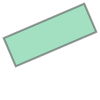

In [8]:
dataframe.iloc[123].geometry.minimum_rotated_rectangle

In [9]:
dataframe.category = dataframe.category.replace("Poli cristaliino", "Poli cristallino")
dataframe = dataframe.dropna(subset=["category"])
dataframe.category.value_counts()

Poli cristallino    8967
Mono cristallino     495
Name: category, dtype: int64

# Utility functions
A mixed set of functions to deal with geospatial imagery.

In [10]:
def mask_to_rgb(mask: np.ndarray, palette:dict) -> np.ndarray:
    """Given an input batch, or single picture with dimensions [B, H, W] or [H, W], the utility generates
    an equivalent [B, H, W, 3] or [H, W, 3] array corresponding to an RGB version.
    The conversion uses the given palette, which should be provided as simple dictionary of indices and tuples, lists
    or arrays indicating a single RGB color. (e.g. {0: (255, 255, 255)})

    :param mask: input mask of indices. Each index should be present in the palette
    :type mask: np.ndarray
    :param palette: dictionary of pairs <index - color>, where colors can be provided in RGB tuple format
    :type palette: Dict[int, Iterable]
    :return: tensor containing the RGB version of the input index tensor
    :rtype: np.ndarray
    """
    lut = np.zeros((256, 3), dtype=np.uint8)
    for index, color in palette.items():
        lut[index] = np.array(color, dtype=np.uint8)
    return lut[mask]

In [11]:
def get_intersections(raster: rio.DatasetReader, panels: gpd.GeoDataFrame, group_by: str) -> Dict[str, list]:
    """Returns a dictionary of intersecting panels, grouped by panel category.

    Args:
        raster (rio.DatasetReader): raster image as dataset format
        panels (gpd.GeoDataFrame): panel dataframe containing a geometry field
        group_by (str): name of the column to use for grouping (category, plant_id,...)

    Returns:
        Dict[str, list]: dictionary of <group_by: list(polygons)>
    """
    # create a dict where the default value is an empty list
    polygons = defaultdict(list)
    bounds = geom.box(*raster.bounds)
    # iterate polygons and store the ones intersecting with the raster bounds, grouped by panel category
    for _, row in panels.iterrows():
        if bounds.intersects(row.geometry):
            intersection = bounds.intersection(row.geometry)
            if isinstance(intersection, geom.MultiPolygon):
                intersection = list(intersection)
                polygons[row[group_by]].extend(intersection)
            else:
                polygons[row[group_by]].append(intersection)
    return polygons


In [12]:
def project(shape: geom.Polygon, from_crs: pyproj.CRS, to_crs: pyproj.CRS = pyproj.CRS(3857)) -> geom.Polygon:
    """Projects the given shape from `from_crs` to `to_crs`, which defaults to pseudo-mercator.

    Args:
        shape (geom.Polygon): shape to be projected
        from_crs (pyproj.CRS): source CRS
        to_crs (pyproj.CRS, optional): destination CRS. Defaults to pyproj.CRS(3857).

    Returns:
        geom.Polygon: reprojected shape
    """
    projection = pyproj.Transformer.from_crs(from_crs, to_crs, always_xy=True).transform
    return ops.transform(projection, shape)


In [13]:
def box_dimensions(shape: geom.Polygon, crs: pyproj.CRS, resolution: float = 1.0) -> Tuple[int, int]:
    """Returns the dimension of the image containing the given shape, with the specified resolution in pixels/m.

    Args:
        shape (geom.Polygon): input shape
        crs (pyproj.CRS): input CRS
        resolution (float, optional): Resolution in pixels/m. Defaults to 1.0.

    Returns:
        Tuple[int, int]: height and width of the resulting raster.
    """
    if crs != pyproj.CRS(3857):
        mercator_shape = project(shape, from_crs=crs)
    else:
        mercator_shape = shape
    minx, miny, maxx, maxy = mercator_shape.bounds
    resx, resy = resolution if isinstance(resolution, tuple) else (resolution, resolution)
    return np.ceil(np.abs(maxx - minx) / resx), np.ceil(np.abs(maxy - miny) / resy)


In [14]:
def crop(raster: rio.DatasetReader, polygons: List[geom.Polygon], min_size: int = 256, padding: Union[tuple, int] = 16) -> Any:
    """Crops the given raster into a rasterio Window containing the given polygons, also padded by the specified amount.

    Args:
        raster (rio.DatasetReader): input raster image in rasterio format
        polygons (List[geom.Polygon]): list of polygons insersecting the image
        min_size (int, optional): minimum crop size for each side, in pixels. Defaults to 256.
        padding (Union[tuple, int], optional): padding for each side, in pixels. Defaults to 16.

    Returns:
        Window: rasterio Window of the crop
    """
    padx, pady = padding if isinstance(padding, tuple) else (padding, padding)
    window = rio.features.geometry_window(raster, polygons, pad_x=padx, pad_y=pady)

    h = max(window.height, min_size)
    w = max(window.width, min_size)
    if h > window.height or w > window.width:
        centroid = geom.MultiPolygon(polygons).centroid
        px, py = src.index(centroid.x, centroid.y)
        window = rio.windows.Window(py - np.ceil(h/2), px - np.ceil(w/2), h, w)
    return window


In [15]:
def store_window(source: rio.DatasetReader, destination: Any, window: rio.windows.Window) -> None:
    """Wrapper around rasterio open and write.

    Args:
        source (rio.DatasetReader): input source to be written
        destination (Any): output file to write into
        window (rio.windows.Window): window to be used to read from the source
    """
    metadata = source.meta.copy()
    metadata.update({
        "height": window.height,
        "width": window.width,
        "transform": rio.windows.transform(window, source.transform)
    })
    with destination.open(**metadata) as dataset:
        dataset.write(source.read(window=window))


In [16]:
def tile_overlapped(image: np.ndarray, tile_size: Union[tuple, int] = 256, channels_first: bool = False) -> np.ndarray:
    """Generates a set of tiles with dynamically computed overlap, so that every tile is contained inside the image
    bounds.

    Args:
        image (np.ndarray): input image to be tiled.
        tile_size (Union[tuple, int], optional): size of the tile in pixels, assuming a square tile. Defaults to 256.
        channels_first (bool, optional): whether the image has CxHxW format or HxWxC. Defaults to False.

    Raises:
        ValueError: when the image is smaller than a single tile

    Returns:
        np.ndarray: numpy array with shape num_tilesH X num_tilesW x tileH x tileW x channels
    """
    if len(image.shape) == 2:
        axis = 0 if channels_first else -1
        image = np.expand_dims(image, axis=axis)
    if channels_first:
        image = np.moveaxis(image, 0, -1)
    # assume height, width, channels from now on
    height, width, channels = image.shape
    tile_h, tile_w = tile_size if isinstance(tile_size, tuple) else (tile_size, tile_size)
    if height <= tile_h and width <= tile_w:
        raise ValueError("Image is smaller than the required tile size")
    # number of expected tiles
    tile_count_h = int(np.ceil(width / tile_h))
    tile_count_w = int(np.ceil(height / tile_w))
    # compute total remainder for the expanded window
    remainder_h = (tile_count_h * tile_h) - height
    remainder_w = (tile_count_w * tile_w) - width
    # divide remainders among tiles as overlap (floor to keep overlap to the minimum)
    overlap_h = int(np.floor(remainder_h / float(tile_count_h - 1))) if tile_count_h > 1 else 0
    overlap_w = int(np.floor(remainder_w / float(tile_count_w - 1))) if tile_count_w > 1 else 0
    # create the empty tensor to contain tiles
    tiles = np.empty((tile_count_h, tile_count_w, tile_h, tile_w, channels), dtype=image.dtype)
    for row in range(tile_count_h):
        for col in range(tile_count_w):
            # get the starting indices, accounting from initial positions
            x = max(row * tile_h - overlap_h, 0)
            y = max(col * tile_w - overlap_w, 0)
            # if it exceeds horizontally or vertically in the last rows or cols, increase overlap to fit
            if (x + tile_h) >= height:
                x -= abs(x + tile_h - height)
            if (y + tile_w) >= width:
                y -= abs(y + tile_w - width)
            # assign tile to final tensor
            tiles[row, col] = image[x:x + tile_h, y:y + tile_w, :]
    return tiles

# Tiling tests
Given that grid splits don't work out quite well, the current procedure to extrapolate panels is the following:
 - group panels by plant ID
 - for each raster image:
   - for each plant and list of polygons:
     - check if the group overlap with the current image
     - crop the group with a minimum size for height and width
     - divide in fixed tiles if one dimension is bigger than the fixed tile size

In [17]:
# gather the 105 images from Alessandria and Asti
raster_tiles = list(glob.glob(str(settings.raster_folder / "*.tif")))
assert len(raster_tiles) == 105

# get the CRS from the first image
with rio.open(raster_tiles[0], driver="GTiff") as src:
    raster_crs = src.crs
str(raster_crs)

'EPSG:32632'

In [ ]:
import json

# gather dataset splits from json file
with open(settings.split_file, "r") as f:
    dataset_splits = json.load(f)
dataset_splits

In [20]:
# reproject panels to be in the same reference system
dataframe = dataframe.to_crs(str(raster_crs))
str(dataframe.crs)

'EPSG:32632'

## Plot some examples
Iterate some images and attempt the tiling mechanism.

/mnt/shared/tmp/ipykernel_2604719/2596211274.py:20: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  intersection = list(intersection)
/mnt/shared/tmp/ipykernel_2604719/2596211274.py:20: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  intersection = list(intersection)


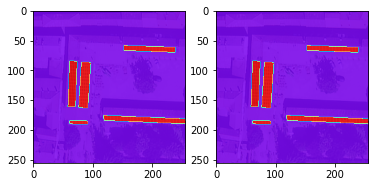

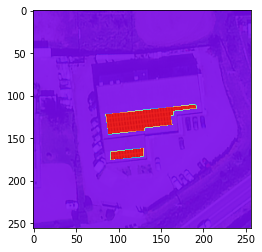

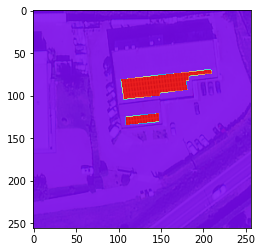

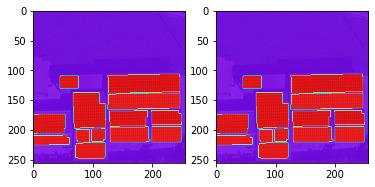

/home/arnaudo/links/dydas/solar-panels-segmentation/.venv/lib/python3.8/site-packages/rasterio/mask.py:90: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '


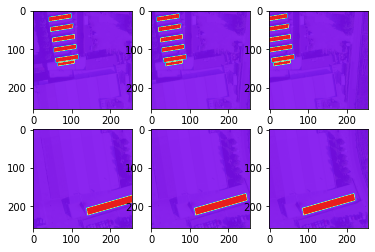

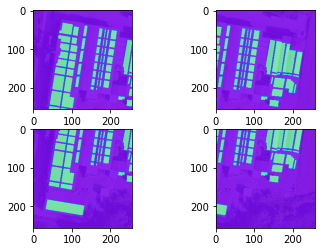

/home/arnaudo/links/dydas/solar-panels-segmentation/.venv/lib/python3.8/site-packages/rasterio/mask.py:90: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '


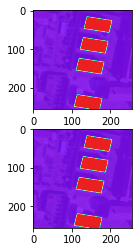

/home/arnaudo/links/dydas/solar-panels-segmentation/.venv/lib/python3.8/site-packages/rasterio/mask.py:90: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '


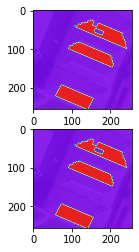

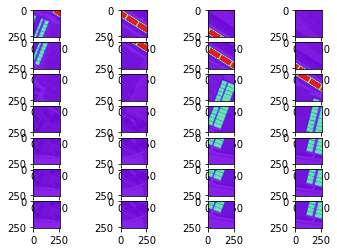

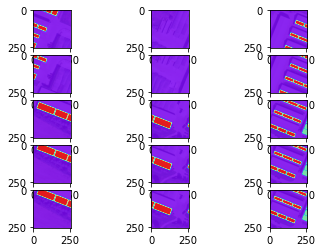

/home/arnaudo/links/dydas/solar-panels-segmentation/.venv/lib/python3.8/site-packages/rasterio/mask.py:90: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '


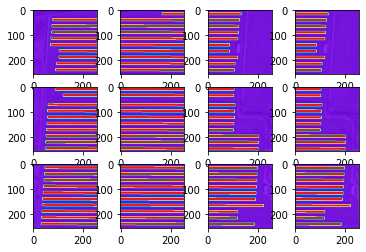

/home/arnaudo/links/dydas/solar-panels-segmentation/.venv/lib/python3.8/site-packages/rasterio/mask.py:90: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '


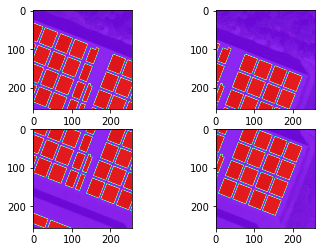

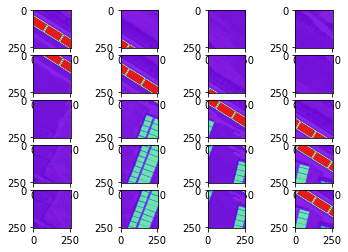

/home/arnaudo/links/dydas/solar-panels-segmentation/.venv/lib/python3.8/site-packages/rasterio/mask.py:90: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '


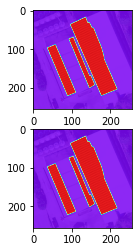

/home/arnaudo/links/dydas/solar-panels-segmentation/.venv/lib/python3.8/site-packages/rasterio/mask.py:90: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '


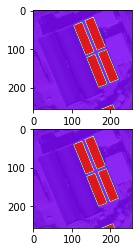

/home/arnaudo/links/dydas/solar-panels-segmentation/.venv/lib/python3.8/site-packages/rasterio/mask.py:90: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '


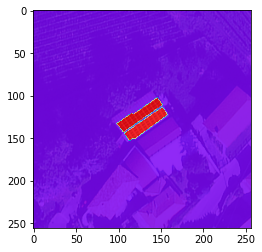

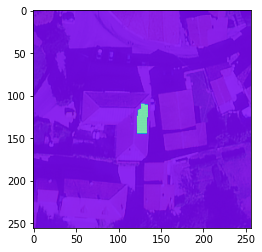

/home/arnaudo/links/dydas/solar-panels-segmentation/.venv/lib/python3.8/site-packages/rasterio/mask.py:90: UserWarning: shapes are outside bounds of raster. Are they in different coordinate reference systems?
  warnings.warn('shapes are outside bounds of raster. '


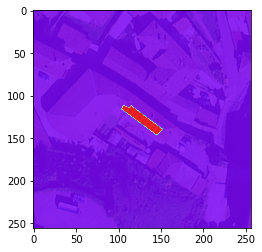

In [21]:
from matplotlib import pyplot as plt

# iterate over 10 raster tiles and open them one by one
for path in raster_tiles[10:20]:
    with rio.open(path, driver="GTiff") as src:
        # get intersecting panels grouped by category and by plant
        intersection_types = get_intersections(src, dataframe, group_by="category")
        intersecting_plant = get_intersections(src, dataframe, group_by="plant_id")
        # iterate dictionary of <plant, panels> (smaller windows)
        for plant_id, polygons in intersecting_plant.items():
            # crop the original image to fit the specific plant
            window = crop(src, polygons, padding=32)
            # prepare a temporary in-memory file to use the window as dataset
            with rio.io.MemoryFile() as tmp:
                store_window(src, tmp, window=window)
                with tmp.open(driver="GTiff") as window_src:
                    rgb = window_src.read()[:3].transpose(1, 2, 0)
                    out_mask = np.zeros(rgb.shape[:2])
                    # generate a mask for each category, on the cropped plant window
                    for category, panels in intersection_types.items():
                        cat_mask, _ = rio.mask.mask(window_src, panels, crop=False, indexes=1)
                        cat_mask = (cat_mask > 0).astype(np.uint8) * settings.class2index[category]
                        out_mask += cat_mask
                    try:
                        # tile mask and image
                        rgb_tiles = tile_overlapped(rgb, channels_first=False)
                        msk_tiles = tile_overlapped(out_mask, channels_first=False)
                    except ValueError as e:
                        # set to one tile for smaller images
                        rgb_tiles = rgb[np.newaxis, np.newaxis, ...]
                        msk_tiles = out_mask[np.newaxis, np.newaxis, ...]
                    rows, cols = rgb_tiles.shape[:2]
                    # plot results
                    fig, axes = plt.subplots(nrows=rows, ncols=cols)
                    if not isinstance(axes, np.ndarray): axes = np.array([[axes]])
                    axes = axes.reshape(rows, cols)
                    for r in range(rows):
                        for c in range(cols):
                            axes[r, c].imshow(rgb_tiles[r, c])
                            axes[r, c].imshow(msk_tiles[r, c], alpha=0.8, cmap="rainbow", vmin=0, vmax=2)
                    plt.show()
                    plt.close(fig)

# Store tiles to file
Iterate on the whole set and save the generated tiles into a folder, defined in the settings.

In [23]:
def store_raster(filename: Path, data: np.ndarray, count: int, channels_first: bool = False, **metadata) -> None:
    # rasterio wants channels first
    if not channels_first:
        data = np.moveaxis(data, -1, 0)
    # create the new file and save data
    with rio.open(filename, mode="w", driver="GTiff", count=count, **metadata) as dst:
        dst.write(data)

In [ ]:
file2split = {}
for split_name, filenames in dataset_splits["splits"].items():
    for filename in filenames:
        file2split[filename] = split_name
file2split

In [ ]:
import tifffile
from tqdm import tqdm


for path in tqdm(raster_tiles):
    # first, get the split it belongs to
    split = file2split.get(Path(path).stem, "train")

    with rio.open(path, driver="GTiff") as src:
        # get intersecting panels grouped by category and by plant
        intersection_types = get_intersections(src, dataframe, group_by="category")
        intersecting_plant = get_intersections(src, dataframe, group_by="plant_id")
        # iterate dictionary of <plant, panels> (smaller windows)
        for plant_id, polygons in intersecting_plant.items():
            # crop the original image to fit the specific plant
            window = crop(src, polygons, padding=32)
            # prepare a temporary in-memory file to use the window as dataset
            with rio.io.MemoryFile() as tmp:
                store_window(src, tmp, window=window)
                with tmp.open(driver="GTiff") as window_src:
                    rgbir = window_src.read().transpose(1, 2, 0)
                    out_mask = np.zeros(rgbir.shape[:2])
                    # generate a mask for each category, on the cropped plant window
                    for category, panels in intersection_types.items():
                        cat_mask, _ = rio.mask.mask(window_src, panels, crop=False, indexes=1)
                        cat_mask = (cat_mask > 0).astype(np.uint8) * settings.class2index[category]
                        out_mask += cat_mask
                    try:
                        # tile mask and image
                        rgbir_tiles = tile_overlapped(rgbir, channels_first=False)
                        mask_tiles = tile_overlapped(out_mask, channels_first=False)
                    except ValueError as e:
                        rgbir_tiles = rgbir[np.newaxis, np.newaxis, ...]
                        mask_tiles = out_mask[np.newaxis, np.newaxis, ...]
                    rows, cols = rgbir_tiles.shape[:2]
                    for r in range(rows):
                        for c in range(cols):
                            # if the tile does not have panels, discard
                            if not np.any(mask_tiles[r, c] > 0):
                                continue
                            # otherwise, store image and mask pairs
                            tile_id = f"{plant_id:06d}_{r:02d}_{c:02d}"
                            image_name = settings.processed_folder / split / "img_dir" / f"{tile_id}.tif"
                            mask_name = settings.processed_folder / split / "ann_dir" / f"{tile_id}.tif"
                            image_name.parent.mkdir(parents=True, exist_ok=True)
                            mask_name.parent.mkdir(parents=True, exist_ok=True)
                            tifffile.imsave(image_name, rgbir_tiles[r, c].transpose(2, 0, 1))
                            tifffile.imsave(mask_name, mask_tiles[r, c])


In [23]:
import tifffile as tif
masks = sorted(glob.glob(str(settings.processed_folder / "*_mask.tif")))
allowed = {0, 1, 2}

for mask in masks:
    img = tif.imread(mask).astype(np.uint8)
    vals = np.unique(img)
    # only 0, 1, 2 allowed
    for v in vals:
        if v not in allowed:
            print(f"Error: image '{mask}' has values: {vals}")
            break
